## Dự đoán giá chứng khoán bằng thuật toán LSTM và Linear Regression

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import metrics
from sklearn import preprocessing;
from sklearn.model_selection import train_test_split
from sklearn import linear_model;
from datetime import datetime
import investpy
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

<h4><center>Crawl data chứng khoán của 3 mã VIC, FPT, GAS, VCB bằng thư viện investpy và lưu vào 3 DataFrame</center></h4>

In [133]:
VIC = investpy.get_stock_historical_data(stock='VIC',
                                        country='VietNam',
                                        from_date='01/01/2012',
                                        to_date='10/06/2022')

FPT =  investpy.get_stock_historical_data(stock='FPT',
                                        country='VietNam',
                                        from_date='01/01/2012',
                                        to_date='10/06/2022')

GAS =  investpy.get_stock_historical_data(stock='GAS',
                                        country='VietNam',
                                        from_date='01/01/2012',
                                        to_date='10/06/2022')

VCB =  investpy.get_stock_historical_data(stock='VCB',
                                        country='VietNam',
                                        from_date='01/01/2012',
                                        to_date='10/06/2022')


<h4><center>Xuất các thông tin cơ bản</center></h4>

In [134]:

VIC.info()
FPT.info()
GAS.info()
VCB.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2228 entries, 2013-07-08 to 2022-06-10
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      2228 non-null   float64
 1   High      2228 non-null   float64
 2   Low       2228 non-null   float64
 3   Close     2228 non-null   float64
 4   Volume    2228 non-null   int64  
 5   Currency  2228 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 121.8+ KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2602 entries, 2012-01-03 to 2022-06-10
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      2602 non-null   float64
 1   High      2602 non-null   float64
 2   Low       2602 non-null   float64
 3   Close     2602 non-null   float64
 4   Volume    2602 non-null   int64  
 5   Currency  2602 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 142.3+ KB


In [135]:
print(FPT.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Currency'], dtype='object')


<h4><center>Xuất 10 dòng cuối</center></h4>

In [136]:
company_list = [FPT, VIC, GAS, VCB]
company_name = ["FPT", "Vingroup", "PetroVietnam", "Vietcombank"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail(10)

,Open,High,Low,Close,Volume,Currency,company_name
Date,,,,,,,
2022-05-30,77400.0,81000.0,76400.0,78000.0,1327400,VND,Vietcombank
2022-05-31,78900.0,78900.0,78000.0,78900.0,483700,VND,Vietcombank
2022-06-01,79000.0,80500.0,79000.0,80500.0,798800,VND,Vietcombank
2022-06-02,80800.0,80800.0,79000.0,79000.0,641400,VND,Vietcombank
2022-06-03,78400.0,79500.0,76400.0,77500.0,527800,VND,Vietcombank
2022-06-06,77500.0,80000.0,75100.0,79700.0,880500,VND,Vietcombank
2022-06-07,79000.0,82000.0,78100.0,81000.0,933000,VND,Vietcombank
2022-06-08,81000.0,81000.0,78800.0,79200.0,1164700,VND,Vietcombank
2022-06-09,79000.0,79900.0,77700.0,77800.0,1067500,VND,Vietcombank


<h4><center>Tổng quan về mã FPT (các giá trị như tổng số dòng, mean, std)</center></h4>

In [137]:
FPT.describe()

,Open,High,Low,Close,Volume
count,2602.000000,2602.000000,2602.000000,2602.000000,2.602000e+03
mean,25457.484435,25748.641507,25199.882629,25467.611299,2.154287e+06
std,21067.382529,21361.249983,20817.616015,21094.132288,1.706773e+06
min,5786.900000,5876.800000,5769.000000,5840.900000,1.896800e+04
25%,12197.600000,12267.875000,12097.700000,12188.200000,9.506460e+05
50%,16824.700000,16968.850000,16644.600000,16788.700000,1.731735e+06
75%,31296.300000,31851.200000,31003.750000,31479.100000,2.867264e+06
max,97083.300000,99083.300000,96000.000000,97166.600000,1.216813e+07


<h4><center>Đồ thị giá đóng sàn của FPT</center></h4>

Text(0.5, 1.0, 'Giá đóng cửa của mã FPT')

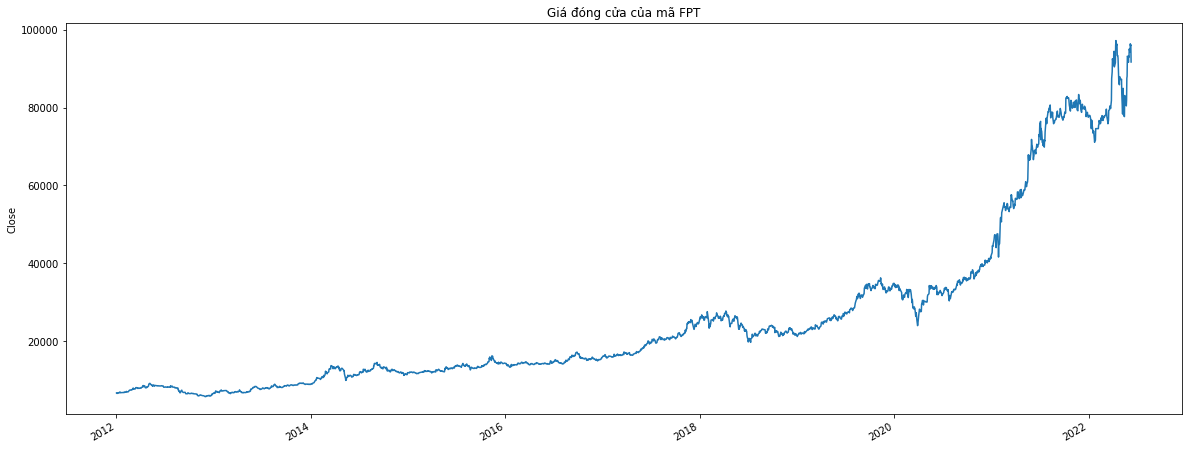

In [138]:
plt.figure(figsize=(20, 8))
# plt.subplots_adjust(top=1.25, bottom=1.2)
FPT['Close'].plot()
plt.ylabel('Close')
plt.xlabel(None)
plt.title(f"Giá đóng cửa của mã FPT")

<h4><center>Đồ thị giá trần, giá sàn, giá đóng cửa và mở cửa</center></h4>

Text(0.5, 1.0, 'Giá đóng, mở, trần và sàn của FPT')

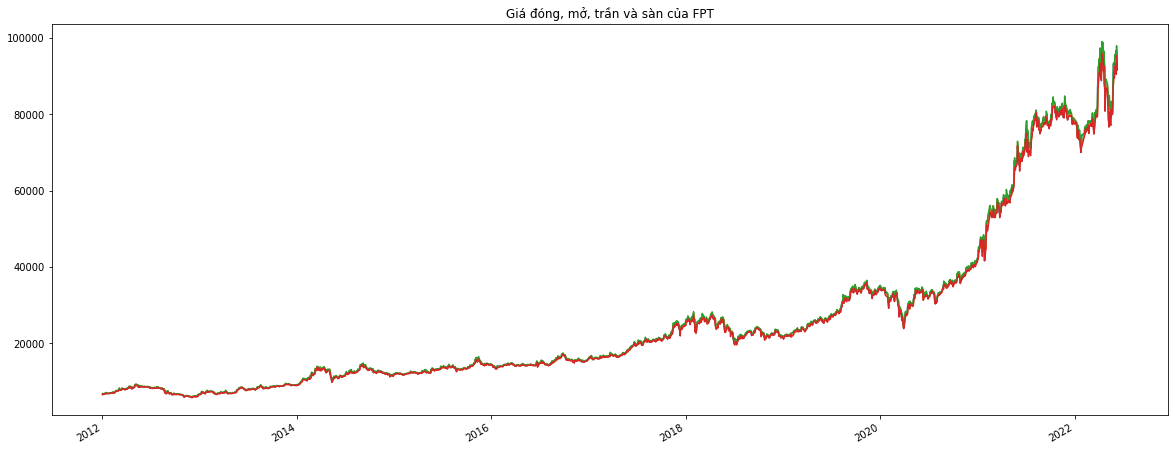

In [139]:
from matplotlib.pyplot import title


plt.figure(figsize=(20, 8))
# plt.subplots_adjust(top=1.25, bottom=1.2)
FPT['Close'].plot()
FPT['Open'].plot()
FPT['High'].plot()
FPT['Low'].plot()
plt.xlabel(None)
plt.title(f"Giá đóng, mở, trần và sàn của FPT")

<h4><center>Tổng giao dịch của FPT trong 1 ngày (đơn vị tính VND)</center></h4>

Text(0.5, 1.0, 'Tổng giá trị giao dịch của mã FPT')

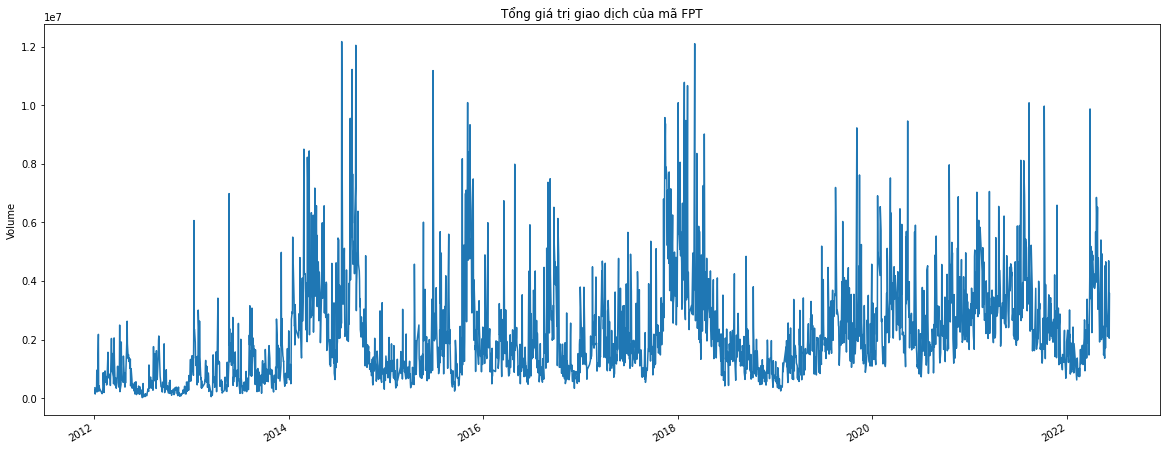

In [140]:
plt.figure(figsize=(20, 8))
# plt.subplots_adjust(top=1.25, bottom=1.2)
FPT['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Tổng giá trị giao dịch của mã FPT")

Đường MA (hay còn gọi là Moving Average) là đường trung bình động, thể hiện biến động, chỉ báo xu hướng của giá cổ phiếu trong một khoảng thời gian, được tính theo công thức lấy trung bình cộng của n ngày trong chu kỳ. Ví dụ MA(10) thì lấy trung bình cộng của 10 ngày đó. 

Đường MA thường lấy các mốc phổ biến như 10, 20 ngày đối với MA ngắn hạn, 50 ngày cho trung hạn và 100 hoặc 200 ngày đối với dài hạn 

In [141]:
ma_day = [10, 20, 30, 50]
for ma in ma_day:
    column_name = f"MA for {ma} days"
    VIC[column_name] = VIC['Close'].rolling(ma).mean()
VIC.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2228 entries, 2013-07-08 to 2022-06-10
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            2228 non-null   float64
 1   High            2228 non-null   float64
 2   Low             2228 non-null   float64
 3   Close           2228 non-null   float64
 4   Volume          2228 non-null   int64  
 5   Currency        2228 non-null   object 
 6   company_name    2228 non-null   object 
 7   MA for 10 days  2219 non-null   float64
 8   MA for 20 days  2209 non-null   float64
 9   MA for 30 days  2199 non-null   float64
 10  MA for 50 days  2179 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 208.9+ KB


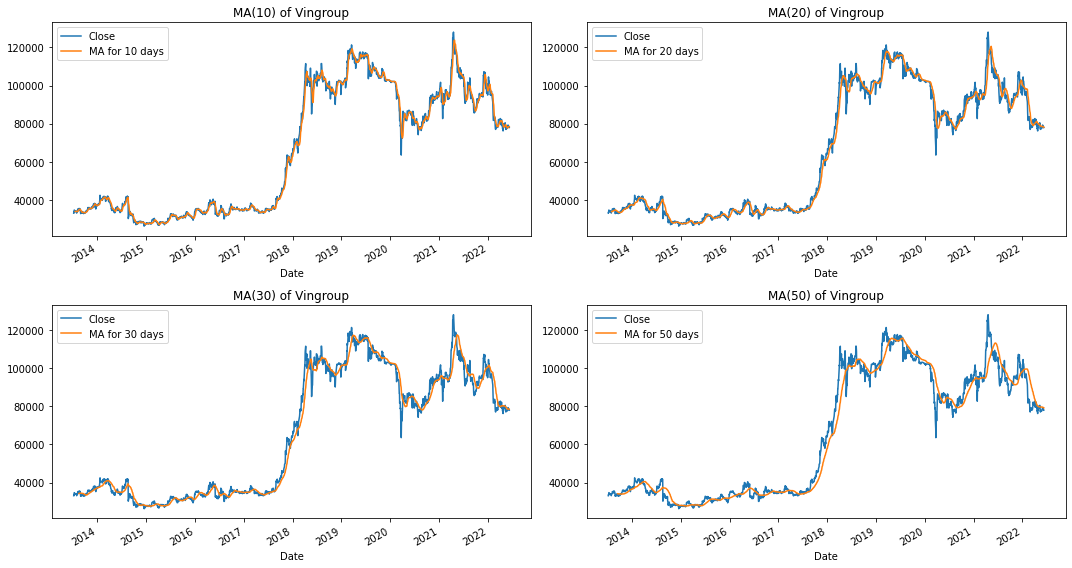

In [142]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)

VIC[['Close', 'MA for 10 days']].plot(ax=axes[0,0])
axes[0,0].set_title('MA(10) of Vingroup')

VIC[['Close', 'MA for 20 days']].plot(ax=axes[0,1])
axes[0,1].set_title('MA(20) of Vingroup')

VIC[['Close', 'MA for 30 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MA(30) of Vingroup')

VIC[['Close', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('MA(50) of Vingroup')

fig.tight_layout()

Daily Return là biểu đồ thể hiện sự chênh lệch của ngày hôm nay so với ngày trước đó. Nếu biên của ngày hôm đó nằm dưới mức 0 thì giá đóng phiên ngày đó thấp hơn ngày hôm trước và ngược lại

In [143]:
FPT['Daily Return'] = FPT['Close'].pct_change()
VCB['Daily Return'] = VCB['Close'].pct_change()
GAS['Daily Return'] = GAS['Close'].pct_change()
VIC['Daily Return'] = VIC['Close'].pct_change()

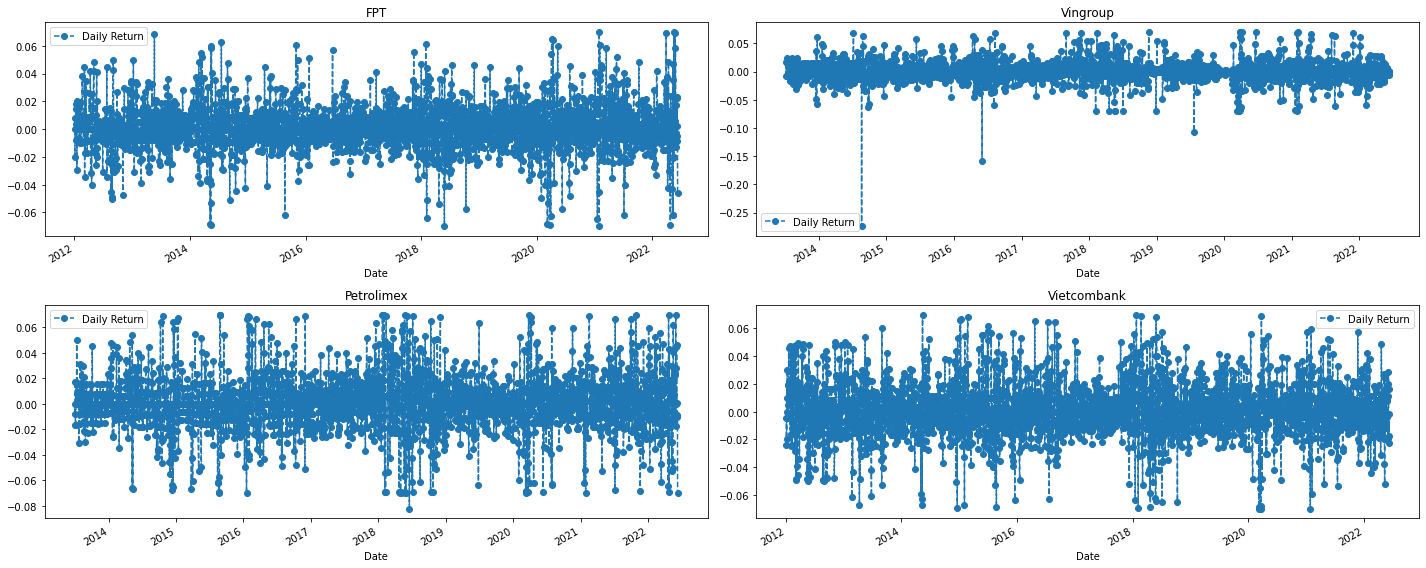

In [144]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(20)

FPT[['Daily Return']].plot(legend=True, linestyle='--', marker='o', ax=axes[0,0])
axes[0,0].set_title('FPT')

VIC[['Daily Return']].plot(legend=True, linestyle='--', marker='o',ax=axes[0,1])
axes[0,1].set_title('Vingroup')

GAS[['Daily Return']].plot(legend=True, linestyle='--', marker='o',ax=axes[1,0])
axes[1,0].set_title('Petrolimex')

VCB[['Daily Return']].plot(legend=True, linestyle='--', marker='o',ax=axes[1,1])
axes[1,1].set_title('Vietcombank')

fig.tight_layout()

<h4><center>Độ rủi ro khi đầu tư vào 4 mã chứng khoán</center></h4>

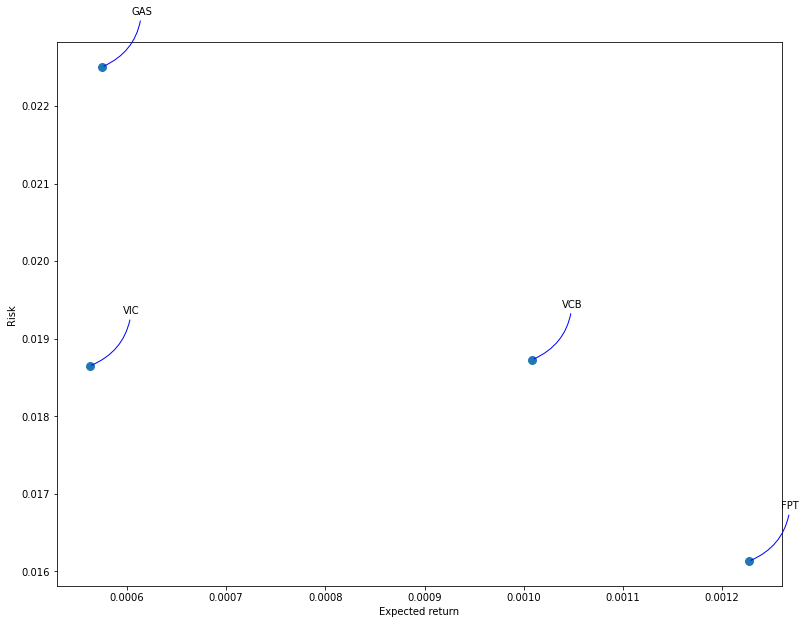

In [145]:
closing_fpt = FPT['Close']
closing_VIC = VIC['Close']
closing_GAS = GAS['Close']
closing_VCB = VCB['Close']

closing_df = pd.concat([closing_fpt, closing_VIC, closing_GAS, closing_VCB], axis=1, keys=['FPT', 'VIC', 'GAS', 'VCB'])
stock_rets = closing_df.pct_change()
rets = stock_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(13, 10))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')
for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

<h2><center>Dự đoán bằng phương pháp Linear Regression</center></h2>

Hàm chia data train và test

In [146]:
def split_data(X,Y):
    return X[:-40], Y[:-40], X[-40:], Y[-40:]

Hàm chuẩn hoá data về khoảng 0 1 và reshape để phù hợp với chuẩn hoá dữ liệu

In [147]:
def data_for_linear(df, timesteps= 40):
    x=FPT.Close.values
    x=x.reshape(-1,1)
    #Normalization
    
    scaler = MinMaxScaler()
    x_noml=scaler.fit_transform(x)
    X=[]; Y=[]
    for i in range(x.shape[0]- timesteps):
        X.append(x_noml[i:i+timesteps])
        Y.append(x_noml[i+timesteps])
    X=np.array(X); Y= np.array(Y)
    X= np.reshape(X, (-1,timesteps))
    print('Input shape:{}, Output shape:{}'.format(X.shape, Y.shape))
    return X,Y, scaler

<h4><center>Chia tập data train test</center></h4>

In [148]:
x_linear, ylinear, lin_scaler= data_for_linear(FPT)
xtrain, ytrain, xtest, ytest= split_data(x_linear, ylinear)

Input shape:(2562, 40), Output shape:(2562, 1)


<h4><center>Tạo model với các siêu tham số (Hyper Parameter)</center></h4>

In [149]:


liner_model= Sequential()
liner_model.add(Dense(128, activation=None, input_shape=(40,)))
liner_model.add(Dense(228, activation=None))
liner_model.add(Dense(64, activation=None))
liner_model.add(Dense(1, activation=None))

liner_model.compile(optimizer='adam', loss='mse')
liner_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 128)               5248      
                                                                 
 dense_37 (Dense)            (None, 228)               29412     
                                                                 
 dense_38 (Dense)            (None, 64)                14656     
                                                                 
 dense_39 (Dense)            (None, 1)                 65        
                                                                 
Total params: 49,381
Trainable params: 49,381
Non-trainable params: 0
_________________________________________________________________


In [150]:
his= liner_model.fit(xtrain, ytrain, epochs=40)

Epoch 1/40
79/79 [==============================] - 1s 2ms/step - loss: 0.0115
Epoch 2/40
79/79 [==============================] - 0s 3ms/step - loss: 1.3759e-04
Epoch 3/40
79/79 [==============================] - 0s 2ms/step - loss: 1.3071e-04
Epoch 4/40
79/79 [==============================] - 0s 3ms/step - loss: 1.3605e-04
Epoch 5/40
79/79 [==============================] - 0s 2ms/step - loss: 1.4325e-04
Epoch 6/40
79/79 [==============================] - 0s 3ms/step - loss: 1.2598e-04
Epoch 7/40
79/79 [==============================] - 0s 3ms/step - loss: 2.2304e-04
Epoch 8/40
79/79 [==============================] - 0s 3ms/step - loss: 1.5805e-04
Epoch 9/40
79/79 [==============================] - 0s 3ms/step - loss: 4.3388e-04
Epoch 10/40
79/79 [==============================] - 0s 2ms/step - loss: 5.4520e-04
Epoch 11/40
79/79 [==============================] - 0s 2ms/step - loss: 6.5349e-04
Epoch 12/40
79/79 [==============================] - 0s 2ms/step - loss: 1.7759e-04
Epoch

Forcasting

In [151]:
#-------------- True Forecasting/predicting future sales--------------------#
ypred=[]
for i in range(xtest.shape[0]-1):
    p= liner_model.predict(xtest[i].reshape(1,40))
    ypred.append(p)
    xtest[i+1, -1]= p
ypred.append(liner_model.predict(xtest[i+1].reshape(1,40)))
#-------------- Note it!------------------------------------------------------#

1/1 [==============================] - 0s 23ms/step


79/79 [==============================] - 0s 2ms/step


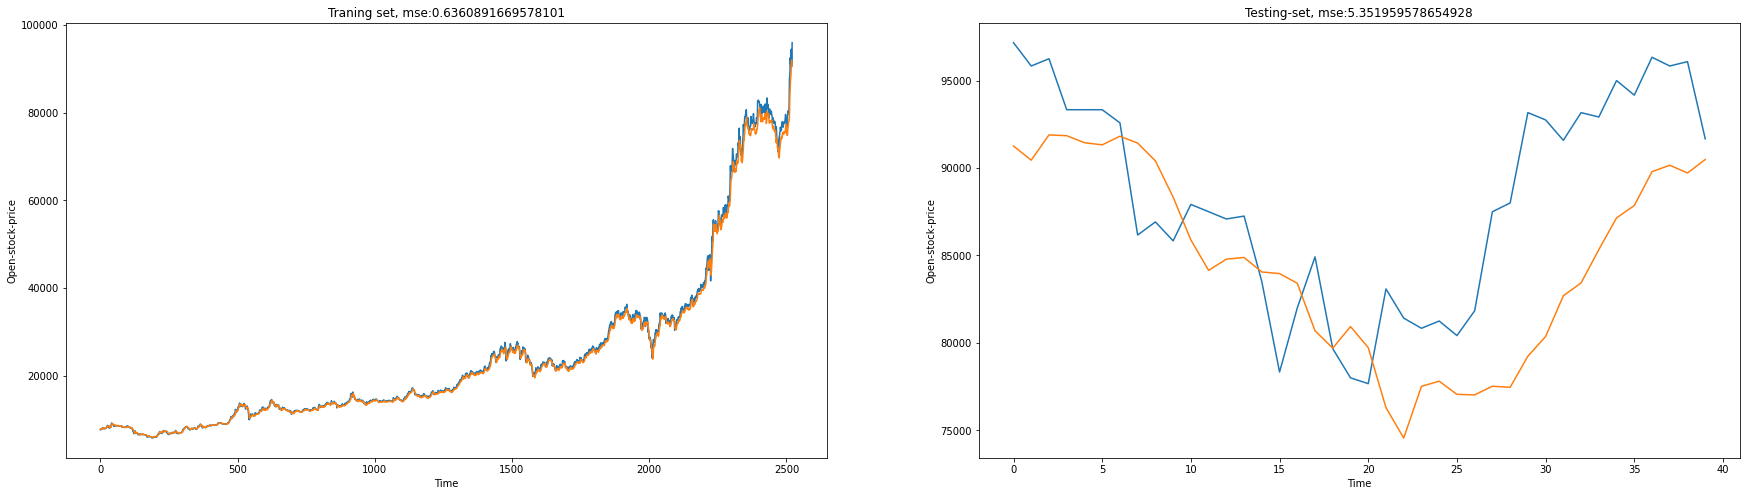

In [152]:

f, ax= plt.subplots(1, 2, figsize=(30,8))
ax[0].plot(lin_scaler.inverse_transform(ytrain))
ax[0].plot(lin_scaler.inverse_transform(liner_model.predict(xtrain)))
ax[0].set_title('Traning set, mse:{}'.format(mean_absolute_error(ytrain, liner_model.predict(xtrain))*100))
ax[0].set_ylabel('Open-stock-price')
ax[0].set_xlabel('Time')

ax[1].plot(lin_scaler.inverse_transform(ytest))
ax[1].plot(lin_scaler.inverse_transform(np.array(ypred).reshape(-1,1)))
ax[1].set_title('Testing-set, mse:{}'.format(mean_absolute_error(ytest, np.array(ypred).reshape(-1,1))*100))
ax[1].set_ylabel('Open-stock-price')
ax[1].set_xlabel('Time')
plt.show()

In [153]:
# train = FPT[:training_data_len]
# valid = FPT[training_data_len:]
# valid['Predictions'] = predictions
# Visualize the data
# plt.figure(figsize=(16,6))
# plt.title('Model')
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Close Price USD ($)', fontsize=18)
# plt.plot(ytest.reshape(-1,1))
# plt.plot(ypred)
# plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
# plt.show()

<h2><center>Dự đoán bằng phương pháp LSTM</center></h2>

In [154]:
# Create a new dataframe with only the 'Close column 
data = FPT.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2472

In [155]:
FPT.describe()

,Open,High,Low,Close,Volume,Daily Return
count,2602.000000,2602.000000,2602.000000,2602.000000,2.602000e+03,2601.000000
mean,25457.484435,25748.641507,25199.882629,25467.611299,2.154287e+06,0.001130
std,21067.382529,21361.249983,20817.616015,21094.132288,1.706773e+06,0.016092
min,5786.900000,5876.800000,5769.000000,5840.900000,1.896800e+04,-0.069841
25%,12197.600000,12267.875000,12097.700000,12188.200000,9.506460e+05,-0.006736
50%,16824.700000,16968.850000,16644.600000,16788.700000,1.731735e+06,0.000000
75%,31296.300000,31851.200000,31003.750000,31479.100000,2.867264e+06,0.008756
max,97083.300000,99083.300000,96000.000000,97166.600000,1.216813e+07,0.069965


In [156]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01047788],
       [0.01047788],
       [0.00896462],
       ...,
       [0.9854006 ],
       [0.98813806],
       [0.93977599]])

In [157]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.01047788, 0.01047788, 0.00896462, 0.00957014, 0.00987236,
       0.01093121, 0.01093121, 0.01032678, 0.01168784, 0.0132011 ,
       0.01093121, 0.01093121, 0.01123452, 0.01123452, 0.01168784,
       0.01123452, 0.01244447, 0.0132011 , 0.01244447, 0.01244447,
       0.01244447, 0.01395774, 0.01471437, 0.01395774, 0.0132011 ,
       0.0132011 , 0.0132011 , 0.01395774, 0.01471437, 0.0177398 ,
       0.0177398 , 0.01849644, 0.01849644, 0.01849644, 0.01925307,
       0.01849644, 0.01925307, 0.01925307, 0.02000861, 0.02379177,
       0.02076524, 0.02303514, 0.02152187, 0.02152187, 0.02152187,
       0.0222785 , 0.0222785 , 0.02530394, 0.02530394, 0.02530394,
       0.02454731, 0.02454731, 0.02303514, 0.02379177, 0.02379177,
       0.02303514, 0.02379177, 0.02379177, 0.02379177, 0.02379177])]
[0.023791769458104337]

[array([0.01047788, 0.01047788, 0.00896462, 0.00957014, 0.00987236,
       0.01093121, 0.01093121, 0.01032678, 0.01168784, 0.0132011 ,
       0.01093121, 0.01093121, 0.0

In [158]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model2 = Sequential()
model2.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dense(25))
model2.add(Dense(1))

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model2.fit(x_train, y_train, batch_size=1, epochs=1)

2412/2412 [==============================] - 81s 32ms/step - loss: 9.5237e-04


In [159]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model2.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 1s 33ms/step


6637.401825807839

In [160]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print(format(mean_absolute_error(predictions, y_test)))

6000.695024038464
